<h1 style="color:#191970"> Classification Models</h1>

<h2 style="color:purple"> Import Necessary Libraries and Modules </h2>

In [384]:
import emailer
import info_grabber as grabber
import data_cleaner as dc 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import visualizer
import sklearn.preprocessing as preproc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error, confusion_matrix
from sklearn.linear_model import LinearRegression, RidgeClassifierCV, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances, calinski_harabaz_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3> Baseline Ridge Classifier Model</h3>

In [79]:
# read in the file
original = pd.read_json("og_data.json").reset_index().drop(["index"], axis=1)

In [80]:
print(original.shape)
print("-------------------------------------------------")
print(original.info())

(1167, 49)
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 49 columns):
rating                           1167 non-null int64
cluster_group                    1167 non-null int64
counts                           1167 non-null int64
name                             1167 non-null object
privatetutor                     1167 non-null int64
review_count                     1167 non-null int64
testprep                         1167 non-null int64
tutoring                         1167 non-null int64
1k_to_1499_rent                  1167 non-null float64
1.5k_to_1,999_rent               1167 non-null float64
150k_plus_salary                 1167 non-null float64
2k_plus_rent                     1167 non-null float64
30k_to_74,999_salary             1167 non-null float64
600_to_999_rent                  1167 non-null float64
75k_to_149,999_salary            1167 non-null float64
1_person_household    

We had to oversample our original data because we had a class imbalance. We will run a baseline model with the original data to see how it performs, then we will work with the oversampled data.

In [280]:
# let's run a model to classify the business by the rating based off the other features.
X = original.drop(["rating", "name", "counts", "privatetutor", "testprep", "tutoring", "cluster_group"], axis=1)
y = original[["rating"]].astype(int).values.flatten()
scaler = preproc.Normalizer()
X_scaled = scaler.fit(X, y).transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=.2, random_state=800)
clf = RidgeClassifierCV().fit(trainX, trainy)
pred = clf.predict(testX)
clf.score(testX, testy)

0.48717948717948717

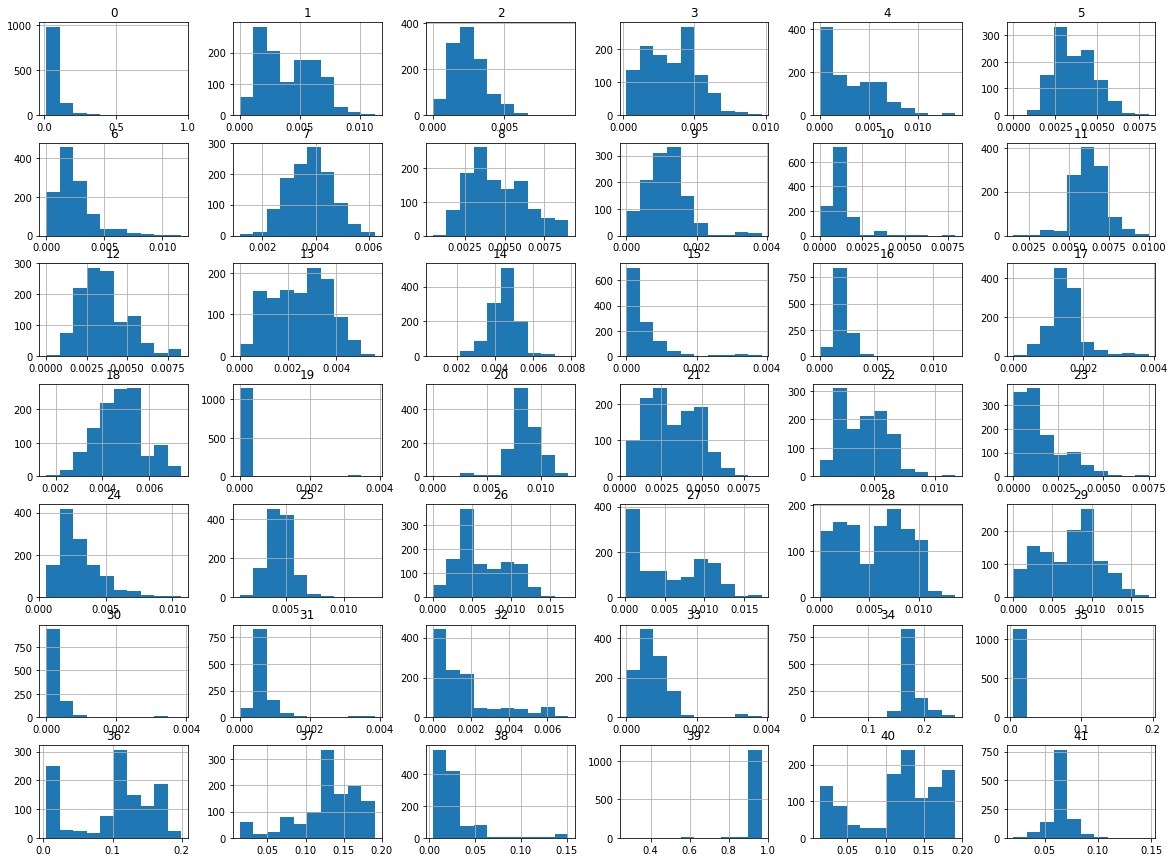

In [186]:
pd.DataFrame(X_scaled).hist(figsize=(20, 15));

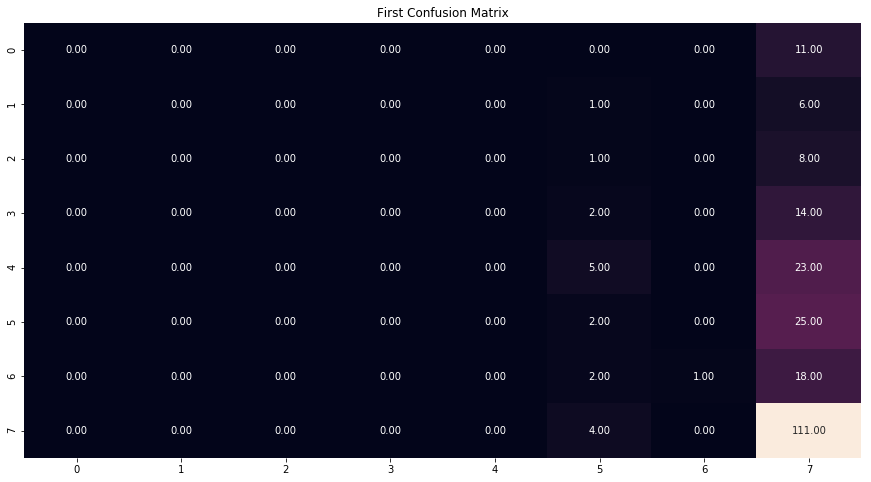

In [311]:
viz = visualizer.Visualizer()
viz.cf_matrix(testy, pred, "First Confusion Matrix")

Our baseline model has a mean accuracy of 50, makes sense since over 50% of our data has a rating 5(7). We can see from our confusion matrix that we did not guess any of the lower ratings. We need to oversample.

In [267]:
# let's run a model to classify the business by the rating based off the other features.
X_smote, y_smote = SMOTE(k_neighbors=4).fit_sample(X_scaled, y)
trainX_smote, testX_smote, trainy_smote, testy_smote = train_test_split(X_smote, y_smote, test_size=.2, random_state=800)

clf_smote = OneVsOneClassifier(RidgeClassifierCV()).fit(trainX_smote, trainy_smote)
pred_smote = clf_smote.predict(testX_smote)
clf_smote.score(testX_smote, testy_smote)

0.4397363465160075

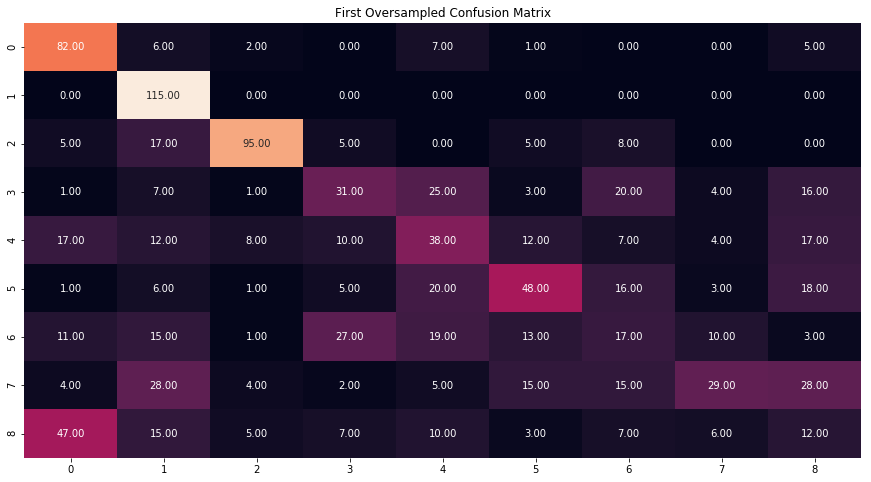

In [310]:
viz.cf_matrix(testy_smote, pred_smote, "First Oversampled Confusion Matrix")

Not great, but at least other ratings are being chosen. 

### Baseline SVM Model

#### SVC

In [270]:
clf3 = SVC().fit(trainX_smote, trainy_smote)
pred3 = clf3.predict(testX_smote)
clf3.score(testX_smote, testy_smote)

0.09698681732580038

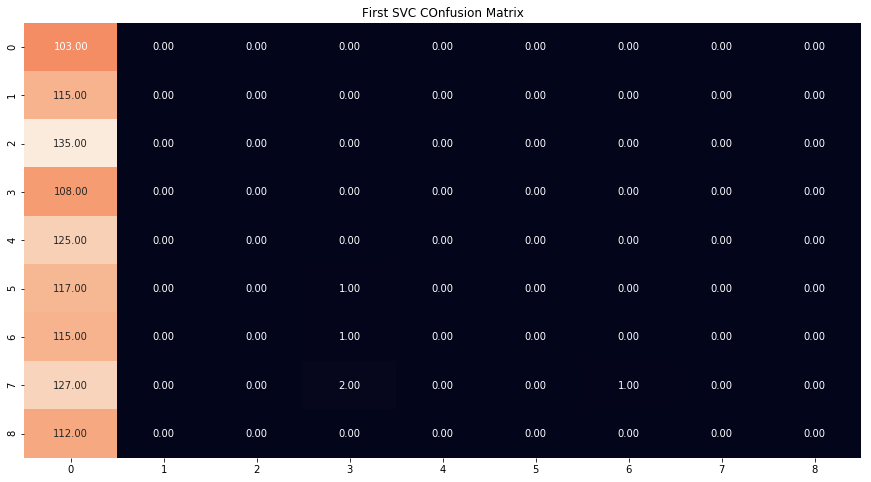

In [309]:
viz.cf_matrix(testy_smote, pred3, "First SVC COnfusion Matrix")

In [258]:
clf3_all = OneVsRestClassifier(SVC()).fit(trainX_smote, trainy_smote)
pred3_all = clf3_all.predict(testX_smote)
clf3_all.score(testX_smote, testy_smote)

0.3154425612052731

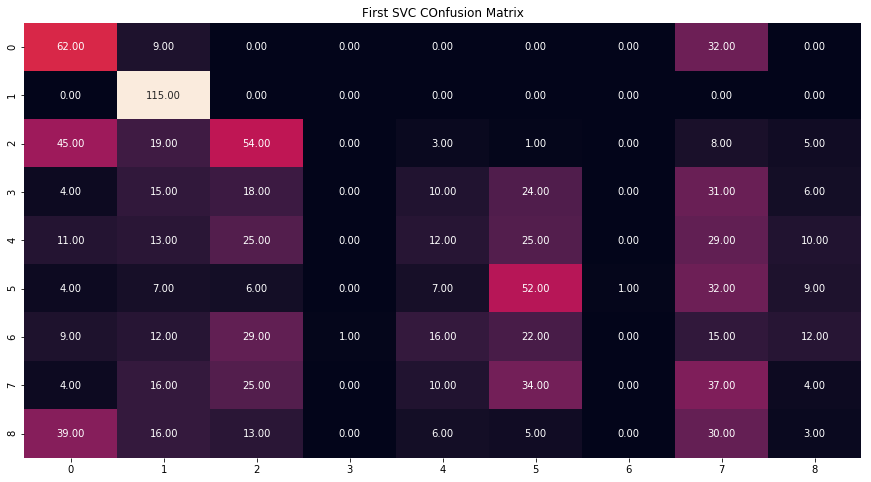

In [308]:
viz.cf_matrix(testy_smote, pred3_all, "First SVC COnfusion Matrix")

### Baseline SGD Model

In [263]:
clf4 = SGDClassifier().fit(trainX_smote, trainy_smote)
pred4 = clf4.predict(testX_smote)
clf4.score(testX_smote, testy_smote)

0.2937853107344633

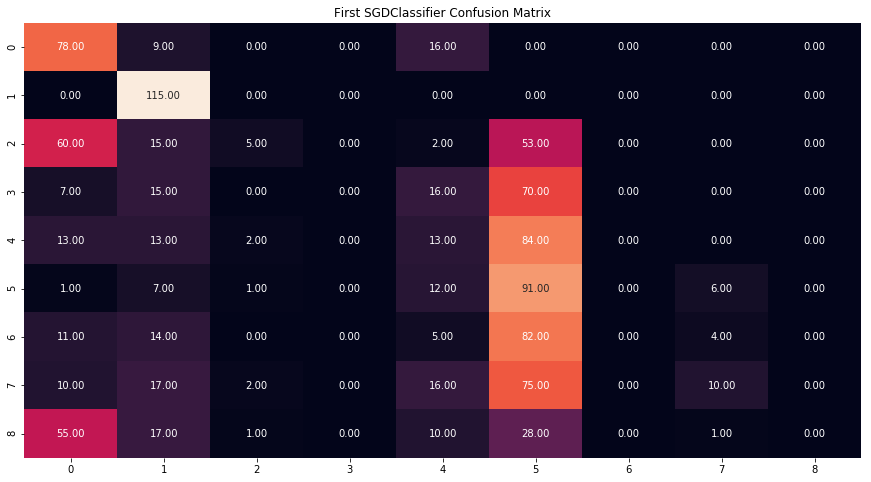

In [307]:
viz.cf_matrix(testy_smote, pred4, "First SGDClassifier Confusion Matrix")

### Baseline KNN

In [303]:
knn = KNeighborsClassifier().fit(trainX_smote, trainy_smote)
pred_knn = knn.predict(testX_smote)
knn.score(testX_smote, testy_smote)

0.8418079096045198

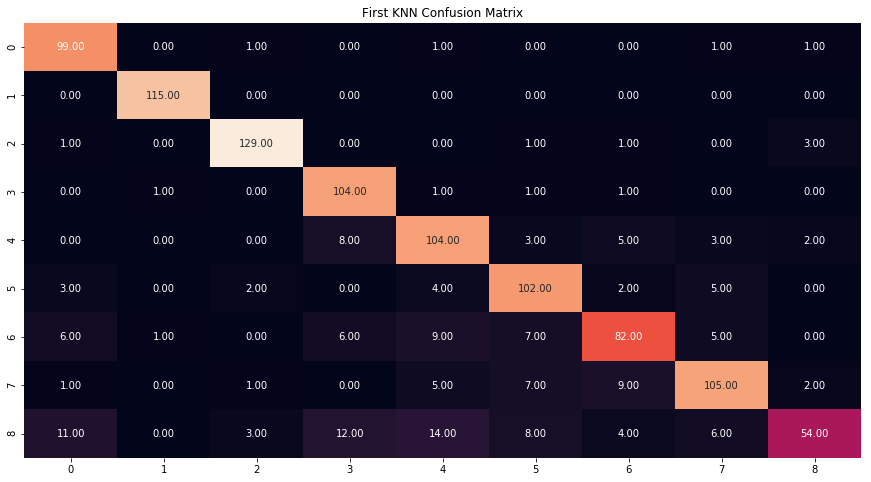

In [304]:
viz.cf_matrix(testy_smote, pred_knn, "First KNN Confusion Matrix")

These are very good results but we used synthetic data to test our model. Next we'll try to only use the upsampling to train but test on raw data.

In [374]:
X = original.drop(["rating", "name", "counts", "privatetutor", "testprep", "tutoring", "cluster_group"], axis=1)
y = original[["rating"]].astype(int).values.flatten()
scaler = preproc.Normalizer()
X_scaled = scaler.fit(X, y).transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=.2, random_state=800)
trainXsmote, trainysmote = SMOTE(k_neighbors=4).fit_sample(trainX, trainy)

Since KNN was our best model. We will start with this.

In [375]:
knn = KNeighborsClassifier().fit(trainXsmote, trainysmote)
pred_knn = knn.predict(testX)
knn.score(testX, testy)

0.45726495726495725

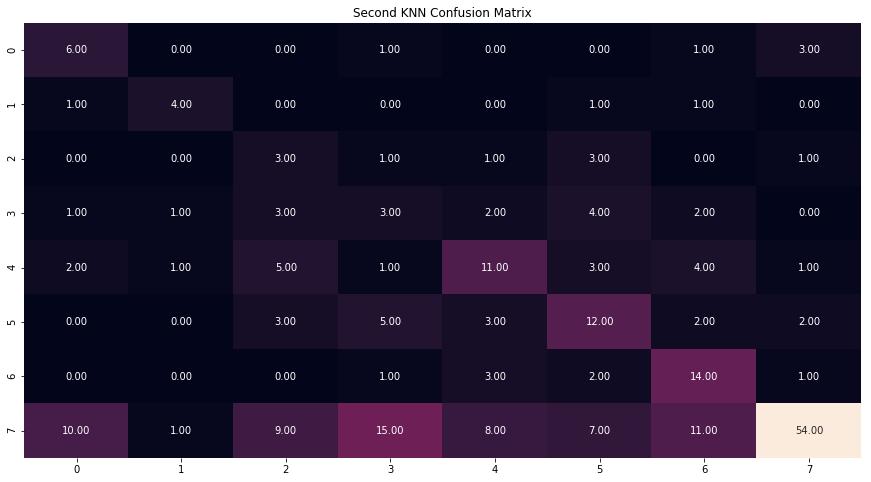

In [376]:
viz.cf_matrix(testy, pred_knn, "Second KNN Confusion Matrix")

In [377]:
rf = RandomForestClassifier().fit(trainXsmote, trainysmote)
pred_rf = rf.predict(testX)
rf.score(testX, testy)

0.5555555555555556

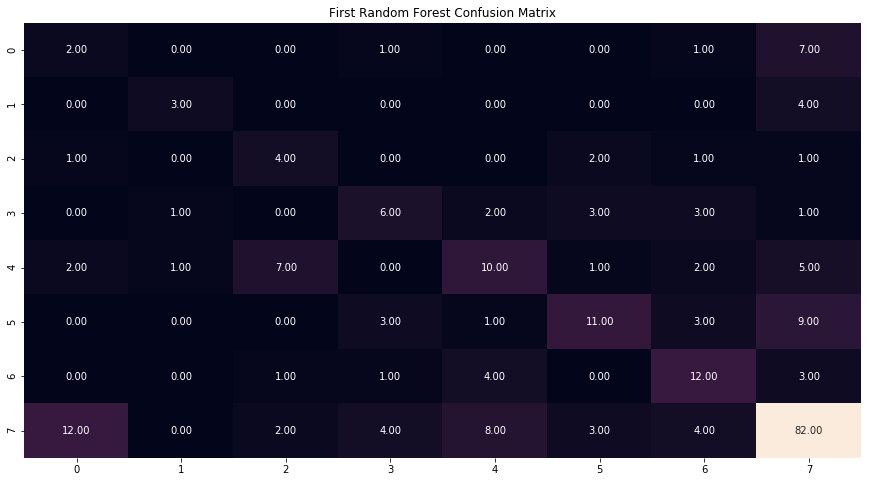

In [378]:
viz.cf_matrix(testy, pred_rf, "First Random Forest Confusion Matrix")

In [379]:
print(classification_report(testy, pred_rf))

              precision    recall  f1-score   support

           1       0.12      0.18      0.14        11
           3       0.60      0.43      0.50         7
           4       0.29      0.44      0.35         9
           5       0.40      0.38      0.39        16
           6       0.40      0.36      0.38        28
           7       0.55      0.41      0.47        27
           8       0.46      0.57      0.51        21
           9       0.73      0.71      0.72       115

   micro avg       0.56      0.56      0.56       234
   macro avg       0.44      0.43      0.43       234
weighted avg       0.57      0.56      0.56       234



In [381]:
xgb_clf = xgb.XGBClassifier().fit(trainX, trainy)
pred_et = et_clf.predict(testX)
et_clf.score(testX, testy)

0.5470085470085471

In [382]:
print(classification_report(testy, pred_et))

              precision    recall  f1-score   support

           1       0.20      0.36      0.26        11
           3       0.60      0.43      0.50         7
           4       0.25      0.44      0.32         9
           5       0.24      0.25      0.24        16
           6       0.53      0.36      0.43        28
           7       0.50      0.33      0.40        27
           8       0.43      0.57      0.49        21
           9       0.74      0.71      0.73       115

   micro avg       0.55      0.55      0.55       234
   macro avg       0.43      0.43      0.42       234
weighted avg       0.58      0.55      0.55       234



Our Random Forest performed better than our KNN see how XGBoost performs.

In [340]:
X = original.drop(["rating", "name", "counts", "privatetutor", "testprep", "tutoring", "cluster_group"], axis=1)
y = original[["rating"]].astype(int).values.flatten()
scaler = preproc.Normalizer()
X_scaled = scaler.fit(X, y).transform(X)
trainX, testX, trainy, testy = train_test_split(X_scaled, y, test_size=.2, random_state=800)
rf_clf = RandomForestClassifier().fit(trainX, trainy)
pred_rf_clf = rf_clf.predict(testX)
rf_clf.score(testX, testy)

0.5897435897435898

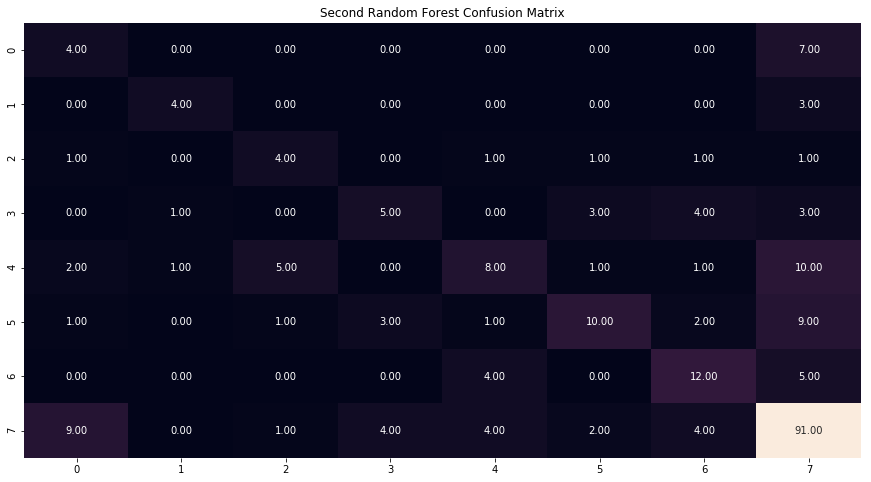

In [342]:
viz.cf_matrix(testy, pred_rf_clf, "Second Random Forest Confusion Matrix")

In [343]:
print(classification_report(testy, pred_rf_clf))

              precision    recall  f1-score   support

           1       0.24      0.36      0.29        11
           3       0.67      0.57      0.62         7
           4       0.36      0.44      0.40         9
           5       0.42      0.31      0.36        16
           6       0.44      0.29      0.35        28
           7       0.59      0.37      0.45        27
           8       0.50      0.57      0.53        21
           9       0.71      0.79      0.75       115

   micro avg       0.59      0.59      0.59       234
   macro avg       0.49      0.46      0.47       234
weighted avg       0.59      0.59      0.58       234



In [370]:
paramgrid = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [10, 5, 3, 20],
    "max_features" : [10, 20, 30]
}
gsrf = GridSearchCV(rf, param_grid=paramgrid, verbose=10, return_train_score=True)
gsrf.fit(trainX, trainy)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] criterion=gini, max_depth=10, max_features=10 ...................
[CV]  criterion=gini, max_depth=10, max_features=10, score=0.5619047619047619, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=10 ...................
[CV]  criterion=gini, max_depth=10, max_features=10, score=0.5852090032154341, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=10 ...................
[CV]  criterion=gini, max_depth=10, max_features=10, score=0.6123778501628665, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=20 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=20, score=0.5587301587301587, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=20 ...................
[CV]  criterion=gini, max_depth=10, max_features=20, score=0.5627009646302251, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=20 ...................
[CV]  criterion=gini, max_depth=10, max_features=20, score=0.5960912052117264, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=30 ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=30, score=0.5365079365079365, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=30 ...................
[CV]  criterion=gini, max_depth=10, max_features=30, score=0.5691318327974276, total=   0.1s
[CV] criterion=gini, max_depth=10, max_features=30 ...................
[CV]  criterion=gini, max_depth=10, max_features=30, score=0.5928338762214984, total=   0.1s
[CV] criterion=gini, max_depth=5, max_features=10 ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, max_features=10, score=0.6412698412698413, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=10 ....................
[CV]  criterion=gini, max_depth=5, max_features=10, score=0.617363344051447, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=10 ....................
[CV]  criterion=gini, max_depth=5, max_features=10, score=0.6482084690553745, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=20 ....................
[CV]  criterion=gini, max_depth=5, max_features=20, score=0.6158730158730159, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=20 ....................
[CV]  criterion=gini, max_depth=5, max_features=20, score=0.6205787781350482, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=20 ....................
[CV]  criterion=gini, max_depth=5, max_features=20, score=0.6384364820846905, total=   0.0s
[CV] criterion=gini, max_depth=5, max_features=30 ....................
[CV]  criterion=gini, m

[CV]  criterion=entropy, max_depth=3, max_features=30, score=0.5396825396825397, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=30 .................
[CV]  criterion=entropy, max_depth=3, max_features=30, score=0.5980707395498392, total=   0.1s
[CV] criterion=entropy, max_depth=3, max_features=30 .................
[CV]  criterion=entropy, max_depth=3, max_features=30, score=0.6254071661237784, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=10 ................
[CV]  criterion=entropy, max_depth=20, max_features=10, score=0.5174603174603175, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=10 ................
[CV]  criterion=entropy, max_depth=20, max_features=10, score=0.5627009646302251, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=10 ................
[CV]  criterion=entropy, max_depth=20, max_features=10, score=0.5700325732899023, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_features=20 ................
[

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   13.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 5, 3, 20], 'max_features': [10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [371]:
gsrf.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10}

In [372]:
gsrf.score(testX, testy)

0.6410256410256411

In [273]:
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk

In [274]:
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1402]:
mini_corp = {"target":test_df.star_rating.to_list(), "data" :test_df.review.to_list()}

In [1405]:
x_train_counts = count_vectorizer.fit_transform(mini_corp["data"])

In [1414]:
count_vectorizer.vocabulary_.get('recommend')

2768

In [1415]:
tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_counts)
x_train_tf = tf_transformer.transform(x_train_counts)

In [1404]:
rdf = reviews_only_df.review.apply(word_tokenize)

In [1417]:
clf = MultinomialNB()
clf.fit(x_train_tf, mini_corp["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [1418]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

In [1420]:
text_clf.fit(mini_corp["data"], mini_corp["target"])

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [1996]:
import gensim
nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')
nltk.download('gutenberg')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [2052]:
import re

In [2152]:
# |[\s]{2,}
pattern = r'([\.\,\'\\(\)\"\-\!\%\\\``\d]|[{.*}?\n]|)'
rev_only_one_df["clean_all_review"] = rev_only_one_df.all_review.apply(lambda x: re.sub(pattern, "", x))

In [2153]:
pattern2 = r'[\s]{2,}'
rev_only_one_df["clean_all_review"] = rev_only_one_df.clean_all_review.apply(lambda x: re.sub(pattern2, " ", x))

In [2156]:
rev_only_one_df["clean_all_review"] = rev_only_one_df["clean_all_review"].str.lower().str.strip("[]")
rev_only_one_df["tokenized"] = rev_only_one_df["clean_all_review"].apply(nltk.word_tokenize)

In [2167]:
rev_only_one_df

,business_name,all_review,clean_all_review,tokenized,tagged
0,Manhattan Prep,"[""I had an absolutely amazing experience in Vi...",i had an absolutely amazing experience in vict...,"[i, had, an, absolutely, amazing, experience, ...","[(i, NN), (had, VBD), (an, DT), (absolutely, R..."
1,180 Degrees LSAT,"[""Larkin is by far the best LSAT tutor in New ...",larkin is by far the best lsat tutor in new yo...,"[larkin, is, by, far, the, best, lsat, tutor, ...","[(larkin, NN), (is, VBZ), (by, IN), (far, RB),..."
2,Bright Kids NYC,"[""Updated review 2 check-ins I received my son...",updated review checkins i received my sons ise...,"[updated, review, checkins, i, received, my, s...","[(updated, VBN), (review, NN), (checkins, VBZ)..."
3,Veritas Prep,"[""I took the in person prep course with Eric M...",i took the in person prep course with eric mal...,"[i, took, the, in, person, prep, course, with,...","[(i, NN), (took, VBD), (the, DT), (in, IN), (p..."
4,Premier Aptitude,['I visited Premier Aptitude a couple of month...,i visited premier aptitude a couple of months ...,"[i, visited, premier, aptitude, a, couple, of,...","[(i, NN), (visited, VBD), (premier, JJR), (apt..."
5,Talent Prep,"[""Updated review Could not have asked for a be...",updated review could not have asked for a bett...,"[updated, review, could, not, have, asked, for...","[(updated, VBN), (review, NN), (could, MD), (n..."
6,MyGuru,['I would recommend MyGuru for test preparatio...,i would recommend myguru for test preparation ...,"[i, would, recommend, myguru, for, test, prepa...","[(i, NN), (would, MD), (recommend, VB), (mygur..."
7,Project Management Academy,['Very satisfied with this class and with my i...,very satisfied with this class and with my ins...,"[very, satisfied, with, this, class, and, with...","[(very, RB), (satisfied, JJ), (with, IN), (thi..."
8,Kweller Prep,['My daughter was accepted to Hunter High Scho...,my daughter was accepted to hunter high school...,"[my, daughter, was, accepted, to, hunter, high...","[(my, PRP$), (daughter, NN), (was, VBD), (acce..."
9,Bee Tutored,"[""First to Review My two daughters attended NY...",first to review my two daughters attended nyc ...,"[first, to, review, my, two, daughters, attend...","[(first, RB), (to, TO), (review, VB), (my, PRP..."


In [2000]:
from nltk.tree import Tree

In [2176]:
rev_only_one_df["clean_all_review"][1000]

' checkins first to review i enrolled my daughter for ballet after hearing great things about this school yolanda has been running this dance academy for over years and is one of the best in the areathey have won tons of trophies at competitionsmy daughter loved her first day and the teacher marianna was really sweet their tutu outfits with leotards are too cuteand its fun watching all the lil girls trying to match their steps i will review this place again once she has completed a term signed up my daughter for ballet and jazz so far so good my daughter likes it and it makes me happy cons only one the waiting area is extremely too small to where some parents have to wait outside in the street waiting room would be nice if it was larger and fit all the parents'

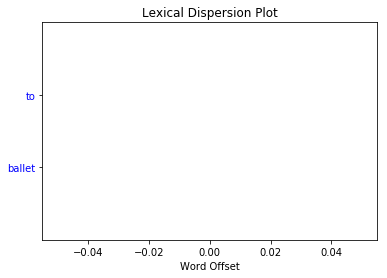

In [2180]:
nltk.draw.dispersion_plot(rev_only_one_df["clean_all_review"][1000], ["to", "ballet"])

Source: <br>
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

In [2161]:
rev_only_one_df["tagged"] = rev_only_one_df["tokenized"].apply(nltk.pos_tag)

In [1990]:
t = Tree("S", rev_only_one_df.tagged[0][:10])

In [1970]:
rev_only_one_df.tagged[0]

[('i', 'NN'),
 ('had', 'VBD'),
 ('an', 'DT'),
 ('absolutely', 'RB'),
 ('amazing', 'JJ'),
 ('experience', 'NN'),
 ('in', 'IN'),
 ('victoria', 'JJ'),
 ('crutchfield', 'NN'),
 ("'s", 'POS'),
 ('gre', 'JJ'),
 ('class', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('i', 'JJ'),
 ("'m", 'VBP'),
 ('certain', 'JJ'),
 ('my', 'PRP$'),
 ('fellow', 'JJ'),
 ('classmates', 'NNS'),
 ('did', 'VBD'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.'),
 ('i', 'VB'),
 ('just', 'RB'),
 ('finished', 'VBN'),
 ('my', 'PRP$'),
 ('last', 'JJ'),
 ('class', 'NN'),
 ('with', 'IN'),
 ('victoria', 'NNS'),
 ('and', 'CC'),
 ('feel', 'VB'),
 ('confident', 'JJ'),
 ('in', 'IN'),
 ('my', 'PRP$'),
 ('ability', 'NN'),
 ('attack', 'VBP'),
 ('the', 'DT'),
 ('gre', 'NN'),
 ('.', '.'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('that', 'IN'),
 (',', ','),
 ('i', 'VB'),
 ('went', 'VBD'),
 ('from', 'IN'),
 ('dreading', 'VBG'),
 ('math', 'NN'),
 ('to', 'TO'),
 ('truly', 'RB'),
 ('enjoying', 'VBG'),
 ('it', 'PRP'),
 ('thanks', 'VBZ'),
 ('to', 'TO'),
 (

In [1890]:
len(df_biz_tri.name.tolist())

1855

In [1896]:
df_biz_tri2 = df_biz_tri[df_biz_tri.name!="Bambini After School"]

In [1873]:
df_biz_tri2.drop(["index"], axis=1, inplace=True)

In [1876]:
df_biz_tri2.name[354]

'Huntington Learning Center'

In [1879]:
df_biz_tri2.name[354] == rev_only_one_df.business_name[354]

True

In [1920]:
reviews_only_df.review.tolist()

["I had an absolutely amazing experience in Victoria Crutchfield's GRE class, and I'm certain my fellow classmates did as well. I just finished my last class with Victoria and feel confident in my ability attack the GRE. More than that, I went from dreading math to truly enjoying it thanks to her enthusiasm and tutelage.  Victoria has every quality of a truly great teacher you can possibly imagine and then some - she really cares about where you're at and how to get you to where you want to be in terms of the material, strategies, and score. I started the class a decade removed from GRE level math and now fully fully confident in my ability to learn any concept and apply the strategies we learned in class to the test. She is incredibly mindful of the class's level of comfort with the material as a whole and always checks in to make sure everyone is understanding explanations, concepts, and strategies.  Highly recommended for anyone at any level. Of comfort with the material.",
 'Elaine